# Iris Using PyMapD and XGBoost

This dataset is brought to you by [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/), and is sourced form [kaggle](https://www.kaggle.com/uciml/iris/data). It includes three iris species with 50 samples each as well as some properties about each flower. One flower species is linearly separable from the other two, but the other two are not linearly separable from each other.

We will be leveraging MapD, Pygdf and XGBoost for performing predective modelling on the dataset usind the belo steps:

1) Get the data. Load it into MapD

2) Extract data from MapD into Pygdf

3) Train and validate xgboost model

4) Use the trained model for prediction

5) Store and see predicted values from MapD

In [6]:
import pandas as pd
import numpy as np
import pymapd
import pygdf
from sklearn import datasets
from pprint import pprint
PWD = "HyperInteractive"

## Load dataset into MapD database

In [7]:
iris = datasets.load_iris()
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
df.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0


In [8]:
# connect mapd
dbname    = 'mapd'
username  = 'mapd'
password  = 'HyperInteractive'
hostname  = 'localhost'
mport     = 9091

con = pymapd.connect(user=username,
                password=password,
                host=hostname,
                dbname=dbname,
                port=mport)

In [9]:
table = 'iris'
_create = '''CREATE TABLE {}(sepal_length double, sepal_width double, petal_length double, petal_width double, target int)'''.format(table)
_drop = '''DROP TABLE IF EXISTS {}'''.format(table)
con.execute(_drop)
con.execute(_create)
# load data
con.load_table(table, df.itertuples(index=False))

## MapD to Pygdf

In [10]:
query = '''Select * from {}'''.format(table)
#df = con.select_ipc_gpu(query)
df = con.select_ipc(query)
df.head(5)

,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [11]:
# separate labels
df_y = df['target']
del df['target']

## XGBoost

### Training

In [12]:
import xgboost as xgb

In [13]:
# gpu to DMatrices
#dtrain = xgb.DMatrix(df.to_pandas(), label=df_y.to_pandas())
dtrain = xgb.DMatrix(df, label=df_y)

In [16]:
params = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3, 
#    'tree_method': 'gpu_hist'
 
}  # the number of classes that exist in this datset
num_round = 20  # the number of training iterations
ear_stop = 20
cv_folds = 5

In [17]:
# cross validation
cvresult = xgb.cv(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_round,
            nfold=cv_folds,
            early_stopping_rounds=ear_stop,
            show_stdv=True)

cvtest = cvresult['test-merror-mean'].min()
cvtrain = cvresult['train-merror-mean'].min()
cvtestsd = cvresult['test-merror-std'].min()
cvtrainsd = cvresult['train-merror-std'].min()

print('CV train loss mean: {}'.format(cvtrain))
print('CV train loss std: {}'.format(cvtrainsd))
print('CV test loss mean: {}'.format(cvtest))
print('CV test loss std: {}'.format(cvtestsd))

# Train
mod = xgb.train(params, dtrain, num_round)

CV train loss mean: 0.0016666
CV train loss std: 0.0033332
CV test loss mean: 0.0266668
CV test loss std: 0.0326600265364


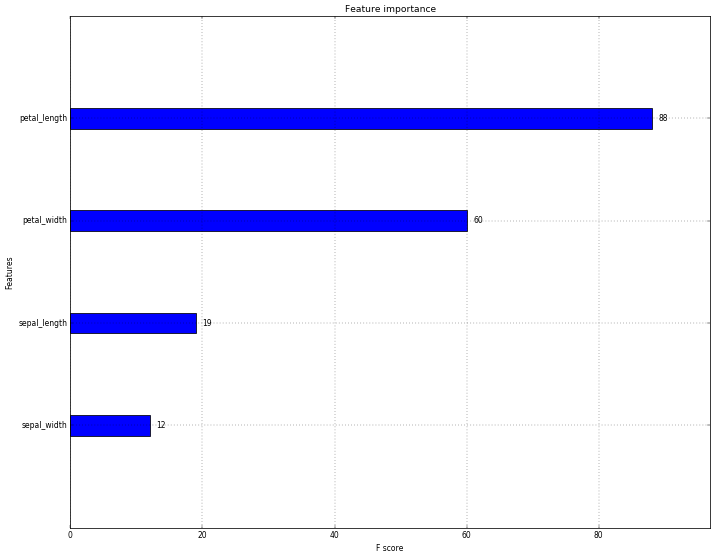

In [18]:
from xgboost import plot_importance
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize']= [15,12]
matplotlib.rcParams['figure.dpi']= 55
plot_importance(mod)
plt.show()

### Prediction

In [19]:
pred = mod.predict(dtrain)
pred_val = np.asarray([np.argmax(line) for line in pred])
pred_val

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])